In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from astropy import constants as const

# FAKE SOURCE EVENTS
Generate a population of fake events across the sky, novae and SNe, from the past ~2000years

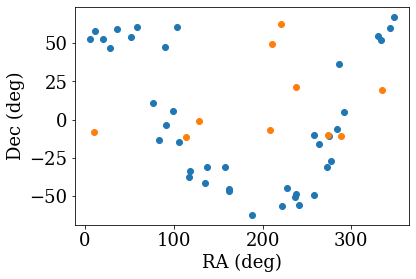

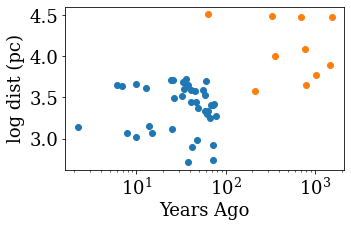

2017.7897614325104


In [4]:
import astropy.coordinates as coord

Nfake = 50
ll = np.random.uniform(low=0., high=360., size=Nfake) * u.deg

# make a band of random events along the galactic plane (novae?)
bb1 = np.random.normal(loc=0., scale=10., size=Nfake - 10) * u.deg
# and a few other events across the sky (SNe)
bb2 = np.random.uniform(low=-90, high=90, size=10) * u.deg
bb = np.concatenate((bb1,bb2))

# put the band of novae at close-ish distances, SNe more spread out in MWY
dd1 = np.random.uniform(low=500,high=5500,size=Nfake-10) * u.pc
dd2 = np.random.uniform(low=2500,high=40000,size=10) * u.pc
dd = np.concatenate((dd1,dd2))

# put novae across time in past 80yrs, SNe over past ~2000yrs
tt1 = np.random.uniform(low=1940, high=2018,size=Nfake-10)
tt2 = np.random.uniform(low=300,high=2018, size=10)
tt = Time(np.concatenate((tt1,tt2)), format='decimalyear')

# combine coordinates & distance, convert to RA,Dec for observing
c1 = SkyCoord(l=ll, b=bb, frame='galactic', distance=dd)
radec = c1.transform_to(coord.FK5)

plt.figure()
plt.scatter(radec.ra[:-10], radec.dec[:-10])
plt.scatter(radec.ra[-10:], radec.dec[-10:])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

plt.figure(figsize=(5,3))
plt.scatter(2020 - tt.value[:-10], np.log10(radec.distance.value)[:-10])
plt.scatter(2020 - tt.value[-10:], np.log10(radec.distance.value)[-10:])
plt.xscale('log')
plt.ylabel('log dist (pc)')
plt.xlabel('Years Ago')
plt.show()

print(max(tt))

In [5]:
# generate errors & time ranges for the fake sources
# assume 0 error in (RA, Dec) at present, but easy to add in later w/ monte carlo on separations

# make broad guesses right now at distance errors. 3% for novae, 8% for SNe?
dd1_err = dd1 * 0.03 
dd2_err = dd2 * 0.08
dd_err = np.concatenate((dd1_err,dd2_err))

# make Novae have 5 day time ranges, SNe 30 day
trng1 = np.ones_like(tt1) * 5/365 * u.day
trng2 = np.ones_like(tt2) * 30/365 * u.day
trng = np.concatenate((trng1,trng2))


# FAKE ALERTS
Generate a LOT of alerts from a fictional observatory over a few year period

start with 1M alerts. An annoyingly large #, but not crushing big

start with a very non-realistic distribution of events uniformly across the sky. 

Improve if needed (unlikely?) Maybe to estimate false positive rate?

goal is to generalize functions to put into an *actual* piece of code, run on ZTF (and someday LSST)

In [6]:
Nalert = 1000000 # start w/ 1M

# this isn't an especially realistic distribution of alerts...
ra_i = np.random.uniform(low=0, high=360, size=Nalert) * u.deg
dec_i = np.random.uniform(low=-20, high=90, size=Nalert) * u.deg

# gaussian distribution in (dist). Most stuff at a few kpc
dd_i = (np.abs(np.random.normal(loc=6e3, scale=1.7e3, size=Nalert)) + 25) * u.pc

# a decade of observations
tt_i = Time(np.random.uniform(low=2018, high=2028, size=Nalert), format='decimalyear')

# make 3D coordinate
c_i = SkyCoord(ra_i, dec_i, distance=dd_i)

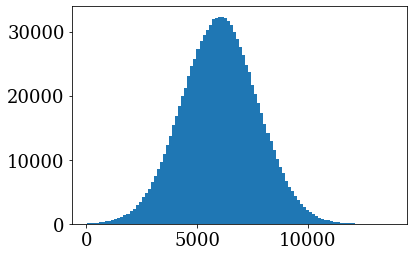

In [7]:
_ = plt.hist(dd_i.value,bins=100)
# plt.yscale('log')

In [8]:
# generate errors & time ranges for the fake alerts
# also no (ra,dec) error, but def should add!

# let's just use 3% errors for distances of alerts right now
dd_i_err = dd_i * 0.03

# no time error for alerts, yet...
# our measurment of NOW is too precise, and we don't know the alert profile in the moment

# Do Ellipse Search

- Go through each Source event (since that's smaller # to loop over)
- compute 3D separation from source to all alerts
- compute 4D ellipse from source to all alerts 
- do we have any intersections?

In [9]:
# # d1 error (dist to alerts)
# dd_i_err[OYES_i].to('lyr')

# # d2 error: (dist between alert and source)
# np.sqrt((dd_err[k].to('lyr')/2)**2 + (dd_i_err[OYES_i].to('lyr'))**2)

# # a error (mostly dist to source):
# dd_err[k].to('lyr')

# # a range, from dt +/- time range
# # a = (((dt.to('s') * const.c) / 2) + c).to('lyr')
# # ((trng[k] + dt.to('s')) * const.c).to('lyr')

# # -> time range of days (even a month) is << 1 lyr (of course), 
# # and is thus dwarfed by distance uncertainties for most stars

In [20]:
etol = 0.1 # ellipse tolerance (in lyr)

d1 = c_i.distance.to('lyr').value # dist to alert stars (from Gaia, presumably)

i=0
# go in time order, oldest event to newest
tsort = np.argsort(tt.value)
for k in tsort:    
    dt = tt_i - tt[k] # time diff from this Source to the alerts

    c = c1[k].distance.to('lyr') / 2 # the Source foci distance
    a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of Source ellipse
    d2 = c_i.separation_3d(radec[k]) # 3D dist (in lyr) between alerts and Sources

    # candidates have distances within the ellipse tolerance, and positive time deltas
    # the latter is important for running this thru archives that may pre-date source events
    OYES_i = (np.abs((d1 + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= etol) & (dt > 0)

    print(i, Time.now().iso[11:], format(tt[k].value, '7.2f'), radec.distance[k], sum(OYES_i))
    i += 1

0 00:39:40.527  376.19 20926.357921004124 pc 7
1 00:39:42.535  393.16 16449.967402325652 pc 0
2 00:39:44.476  519.52 3498.962409955723 pc 0
3 00:39:46.335  548.78 20172.539933587163 pc 4
4 00:39:48.266 1348.60 19001.708099219333 pc 8
5 00:39:50.097 1436.28 36095.78478200441 pc 0
6 00:39:51.962 1444.44 10346.148375655746 pc 8
7 00:39:53.800 1515.14 39375.9654592171 pc 0
8 00:39:55.742 1527.54 11340.2399400615 pc 2
9 00:39:57.567 1662.39 27747.921259786315 pc 0
10 00:39:59.412 1941.11 4651.799699295076 pc 1
11 00:40:01.254 1941.36 2595.701434346136 pc 0
12 00:40:03.199 1942.11 4968.343202619116 pc 0
13 00:40:05.140 1943.38 5216.709698140952 pc 2
14 00:40:07.033 1949.65 5103.772806273524 pc 1
15 00:40:08.933 1950.67 5104.281798590232 pc 2
16 00:40:10.779 1951.13 1723.1700195166152 pc 0
17 00:40:12.632 1953.43 2237.624274349087 pc 0
18 00:40:14.490 1954.95 2457.0694410869955 pc 0
19 00:40:16.345 1956.64 1794.1697203847273 pc 0
20 00:40:18.188 1956.85 4400.099777097923 pc 1
21 00:40:20.041 

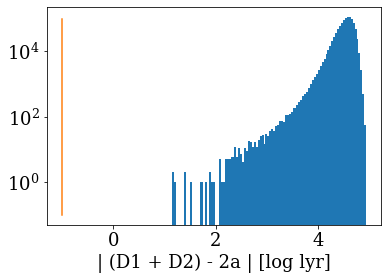

In [21]:
_ = plt.hist(np.log10(np.abs((d1 + d2.to('lyr').value) - (2 * a.to('lyr').value))),bins=100)
plt.yscale('log')
plt.xlabel('| (D1 + D2) - 2a | [log lyr]')

plt.plot([np.log10(etol), np.log10(etol)],[0.1,1e5])

In [13]:
# OYES_i = np.abs((d1 + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= etol
# print(d1[OYES_i], d2.to('lyr').value[OYES_i], radec[k].distance,(2 * a.to('lyr').value)[OYES_i])
# print((d1[OYES_i] + d2.to('lyr').value[OYES_i]) - (2 * a.to('lyr').value)[OYES_i])

in real production mode: 
- we'll have uncertainties on observables for the alerts, 
- should include errors or ranges for the source events (e.g. SNe aren't point-in-time events). 
- I need to add this to my simulation now to get a sense of impact on tolerance factor for coarse match step. 
    - One way to do this is to pick a bigger than wanted tolerance for coarse match 
    - then if some errors don't propgate nicely we can do simple monte carlo for the matches to get better uncertainties (e.g. D2 won't have easy error propgation, I think, but maybe can be done approximately adding both D1 and C errors togeather)

- dwarf novae should be 2-20 days
- SNe should be ~30 days


# Novae
Prep the list of galactic novae... we'll need distances from Gaia

So far this looks like the best single-point source for Novae:
https://github.com/Bill-Gray/galnovae

In [5]:
from astropy.table import Table

In [6]:
# cleaned up table a little bit
tbl = Table.read('galnovae.txt', format='ascii.fixed_width_no_header', 
                 col_starts=(0, 14, 19, 22, 31, 44, 59, 73, 103, 110, 118, 140), 
                 names=('NOVA', 'YEAR', 'MM', 'DD', 'VARIABLE', 'RA', 'DEC', 
                        'mags', 'T3', 'CLASS', 'OBSCURE XID', 'DISCOVERER(S)'), 
                 data_start=1)

df = tbl.to_pandas()

/Users/james/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'MM' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# c_i = SkyCoord(ra_i, dec_i, distance=dd_i)
# df_out = pd.DataFrame(data={'RA':df['RA'], 'DEC':df['DEC']})
# df_out.to_csv('galnovae.csv') # for matching to Gaia....

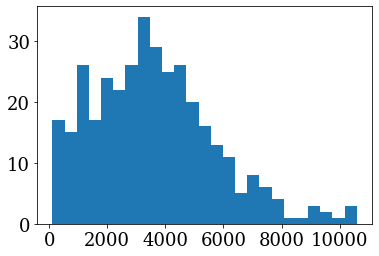

In [8]:
gdata0 = pd.read_csv('EDR3_xmatch_2arcsec.csv')
gdata = pd.read_csv('DR2BJ_xmatch_2arcsec.csv')
# gdata.columns
_ = plt.hist(gdata['rest'], bins=25)

In [9]:
mtch = np.zeros(len(df), dtype='int')-1
# i'm too lazy to figure out the pandas merge w/ this right now...
for k in range(len(df)):
    ok = gdata['col1'] == k
    if sum(ok) > 0:
        mtch[k] = np.where(ok)[0][0]
# mtch

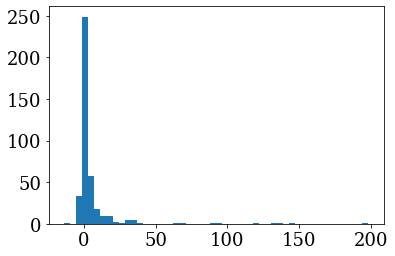

In [10]:
_ = plt.hist(gdata0['parallax_over_error'],bins=50)

In [11]:
# gdata['rest'][mtch[mtch > 0]]
# df['YEAR'][mtch > 0]
# gdata

In [12]:
# pick novae w/ valid times
aok = np.where(np.isfinite(df['YEAR']) & np.isfinite(df['MM']) &  np.isfinite(df['DD']) & 
               (df['MM'] <= 12) & (mtch > 0))[0]

In [21]:
# these are the structures we need: times and skycoords
tt = Time({'year': df['YEAR'].values[aok], 'month': df['MM'][aok].astype('int').values, 
           'day': df['DD'][aok].astype('int').values}, format='ymdhms')

tsort = np.argsort(tt.value)

cc = SkyCoord(ra=gdata['RA_ICRS'][mtch[aok]].values[tsort] * u.deg, 
              dec=gdata['DE_ICRS'][mtch[aok]].values[tsort] * u.deg, 
              distance=gdata['rest'][mtch[aok]].values[tsort] * u.pc)

dfout = pd.DataFrame(data={'RA':gdata['RA_ICRS'][mtch[aok]].values[tsort], 
                           'Dec':gdata['DE_ICRS'][mtch[aok]].values[tsort],
                           'dist':gdata['rest'][mtch[aok]].values[tsort], 
                           'year': df['YEAR'][aok].values[tsort], 
                           'month': df['MM'][aok].astype('int').values[tsort], 
                           'day': df['DD'][aok].astype('int').values[tsort]})

# add SN 1987A
dfout = dfout.append({'RA':83.86675, 'Dec':-69.26974167,'dist':51400.0,
                      'year':1987, 'month':2,'day':23 }, ignore_index=True)



# THIS IS THE FILE YOU NEED TO RUN THE ACTUAL SEARCH
dfout.to_csv('SOURCES_20210419.csv') # the date this was prepped

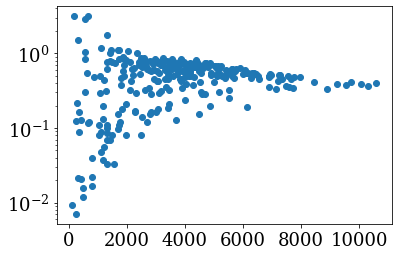

In [17]:
plt.scatter(gdata['rest'][mtch[aok]].values, 
            (gdata['B_rest'][mtch[aok]].values - 
             gdata['b_rest'][mtch[aok]].values) / gdata['rest'][mtch[aok]].values/2)

plt.yscale('log')